In [1]:
from pathlib import Path
import os
from os.path import join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import re
from gelgenie.segmentation.helper_functions.general_functions import create_dir_if_empty
from collections import defaultdict

In [2]:
# Update your paths here
gg_path = Path("/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/quantitative_results/qupath_data/james_data_v3_fixed_global/Data_with_norm_and_corrections")
ga_path = Path("/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/quantitative_results/gelanalyzer")
reference_path = Path("/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/quantitative_results/reference_ladder_masses.csv")

In [26]:
def identify_ladder_names_from_files(folder_path):
    """
    Reads in and assigns each gel a ladder type
    """
    ladder_dict = {}  
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv"):
            file_number = int(filename.split("_")[0])
            ladder_name = filename.split("_")[1]
            ladder_dict[file_number] = ladder_name
    return ladder_dict

def load_gg_csv_files_to_dict(folder_path, prefix="prefix_"):
    """
    Load CSV files from a folder and create a dictionary of DataFrames with prefixed keys.

    Parameters:
    - folder_path (str): The path to the folder containing CSV files.
    - prefix (str): The prefix to be added to the keys of the dictionary (default is "prefix_").

    Returns:
    - dataframes_dict (dict): A dictionary where keys are prefixed numbers, and values are corresponding DataFrames.
    """
    dataframes_dict = {}  # Dictionary to store DataFrames

    # Iterate through files in the folder
    for filename in os.listdir(folder_path):
        # Check if the file is a CSV file
        if filename.endswith(".csv"):
            # Extract the number from the filename
            file_number = filename.split("_")[0]

            # Read the CSV file into a DataFrame
            file_path = os.path.join(folder_path, filename)
            dataframe = pd.read_csv(file_path)

            # Add the prefix to the number and use it as the key in the dictionary
            key = f"{prefix}{file_number}"
            dataframes_dict[key] = dataframe

    return dataframes_dict
def load_ga_csv_files_from_folders(parent_folder, prefix="ga_"):
    """
    Load CSV files from folders and create a dictionary of DataFrames with prefixed names.

    Parameters:
    - parent_folder (str): The path to the parent folder containing numbered subfolders.
    - prefix (str): The prefix to be added to the names of the DataFrames (default is "ga_").

    Returns:
    - dataframes (dict): A dictionary where keys are prefixed folder names, and values are corresponding DataFrames.
    """
    dataframes = {}  # Dictionary to store DataFrames

    # Iterate through folders in the parent folder
    for folder_name in os.listdir(parent_folder):
        folder_path = os.path.join(parent_folder, folder_name)

        # Check if the item in the parent folder is a directory
        if os.path.isdir(folder_path):
            csv_file_path = os.path.join(folder_path, "collated_data_with_band_quality.csv")

            # Check if "collated_data_with_band_quality.csv" exists in the folder
            if os.path.isfile(csv_file_path):
                # Read the CSV file into a DataFrame
                dataframe = pd.read_csv(csv_file_path)
                dataframe = dataframe.rename(columns={'Raw Volume':'GA-Raw-Vol', 'Background Corrected Volume':'GA-BC-Vol'})

                # Add the prefix to the folder name and use it as the key in the dictionary
                prefixed_folder_name = f"{prefix}{folder_name}"
                dataframes[prefixed_folder_name] = dataframe

    return dataframes

In [27]:
# loads in GG data
gg_dfs = load_gg_csv_files_to_dict(gg_path, "gg_") # loads data and converts to dictionary
gg_dfs = {key: gg_dfs[key] for key in sorted(gg_dfs.keys(), key=lambda s: [int(t) if t.isdigit() else t.lower() for t in re.split(r'(\d+)', s)])}  # sorts by gel ID

# loads in GA data
ga_dfs = load_ga_csv_files_from_folders(ga_path)
ga_dfs = {key: ga_dfs[key] for key in sorted(ga_dfs.keys(), key=lambda s: [int(t) if t.isdigit() else t.lower() for t in re.split(r'(\d+)', s)])} # sorts by gel ID

# loads in ladder values
ladder_dict = identify_ladder_names_from_files(gg_path)

# reads in, combines and formats ladder reference mass values
reference_df = pd.read_csv(reference_path)
reference_df.rename(columns={"NEB ladder": "NEB", " ThermoFisher ladder": "Thermo"}, inplace=True)
reference_df["Band ID"] = range(1, len(reference_df) + 1)
reference_df = pd.melt(reference_df, id_vars=["Band ID"], value_vars=["NEB", "Thermo"], var_name="Ladder", value_name="Intensity")
reference_df['Normalized_Intensity'] = reference_df.groupby("Ladder")["Intensity"].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

In [28]:
#1 removes bands from both gg and ga that have the low quality mark from ga
#2 removes bands that are not present in both ga and gg
#3 gels 28 and 30 have been completely excluded from analysis as bands cannot be identified properly (done prior to this notebook)
#4 combines all data into a single dataframe for each gel
origin_data = {} # this contains the combined GA and GG data
for key, df in ga_dfs.items():
    id = int(key.split('_')[-1])
    dfgg =  gg_dfs['gg_%s' % id]
    merged_df = pd.merge(df, dfgg, on=['Lane ID', 'Band ID'])
    filtered_df = merged_df[merged_df['Reliable Band'] == 1]
    origin_data[id] = filtered_df

In [30]:
# Bins each band in terms of rectangularity i.e. how rectangular a band is, intensity and background intensity (calculated from the background found by the local background detection system)
# Each 'Cat_' column contains the categorised value for all 3 quantities
# TODO: check that everything is worked properly as intended here, and see if any hardcoded values can be removed
for key, val in origin_data.items():
    val['Rectangularity'] = val['Pixel Count']/(val['Width']*val['Height'])
    val['Cat_Rectangularity'] = pd.cut(val['Rectangularity'], bins=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], labels=False)
    if key in ['gg_29', 'gg_30']:
        val['Rel.A. Intensity'] = val['Average Intensity']/65535
        val['Rel.S. Intensity'] = val['Intensity SD']/65535
    else:
        val['Rel.A. Intensity'] = val['Average Intensity']/255
        val['Rel.S. Intensity'] = val['Intensity SD']/255
    
    val['Background Level'] = (val['Raw Volume'] - val['Local Corrected Volume'])/(val['Raw Volume'])

    val['Cat_Intensity'] = pd.cut(val['Rel.A. Intensity'], bins=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], labels=False)
    
    val['Cat_Background'] = pd.cut(val['Background Level'], bins=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.1,1.2,1.3], labels=False)

    # print(key, val['Rel.A. Intensity'].max(), val['Rel.S. Intensity'].max(), val['Background Level'].max())


In [102]:
# functions for adaptive normalisation
def norm_by_lane(df, norm_col, lane_col = 'Lane ID'):
    """
    Direct min-max normalisation, grouped by the Lane ID
    """

    min_values = df.groupby(lane_col)[norm_col].transform('min')
    max_values = df.groupby(lane_col)[norm_col].transform('max')

    return (df[norm_col] - min_values)/(max_values-min_values)
    
def adaptive_normalisation(data_dict, ladder_dict, columns_to_extract):
    """
    Since some lanes have bands missing, the ladder normalisation needs to be re-calculated to match the number of bands available.
    This function runs the adaptive normalisation and fuses the reference ladder data with the band data.
    """
    temp_combo_df = origin_data[gelid][columns_to_extract].copy()
    temp_combo_df['Reference Value'] = 0
    for lane in data_dict['Lane ID'].unique():
        
        available_bands = data_dict[data_dict['Lane ID'] == lane]['Band ID'].unique()
        ladder_crop = ladder_dict[ladder_dict['Band ID'].isin(available_bands)].copy() # only retain the bands that are available in the data

        # usual norm here
        min_value = ladder_crop['Reference Value'].min()
        max_value = ladder_crop['Reference Value'].max()
        ladder_crop['Reference Value'] = (ladder_crop['Reference Value'] - min_value) / (max_value - min_value)
        ladder_crop['Lane ID'] = lane

        # combine data together here
        temp_combo_df.set_index(['Lane ID', 'Band ID'], inplace=True)
        ladder_crop.set_index(['Lane ID', 'Band ID'], inplace=True)
        temp_combo_df.update(ladder_crop['Reference Value'])
        
        # Reset the indices to make them regular columns
        temp_combo_df.reset_index(inplace=True)
        ladder_crop.reset_index(inplace=True)
  
    return temp_combo_df


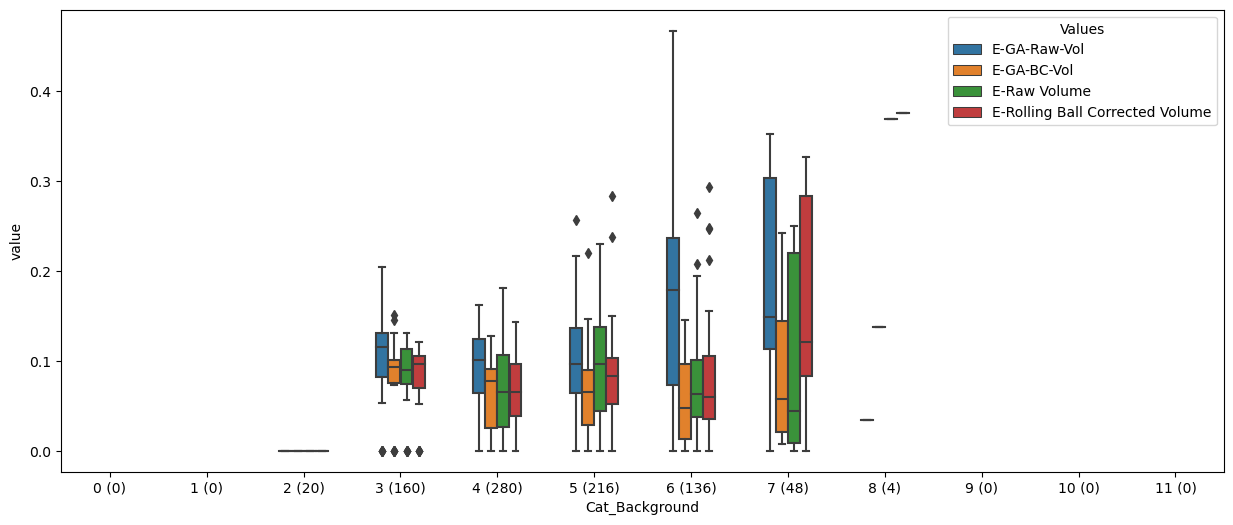

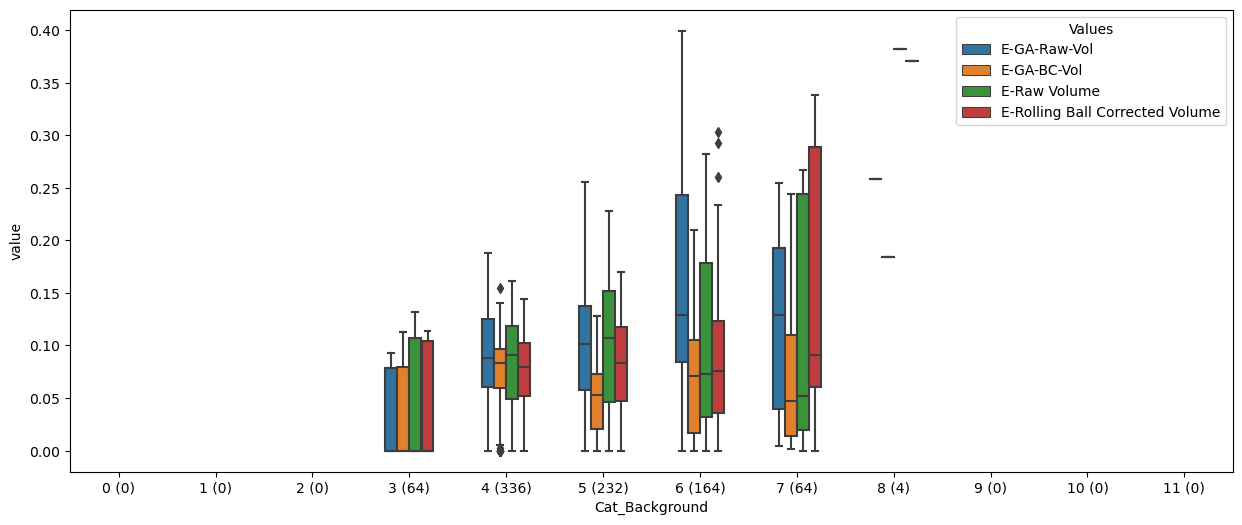

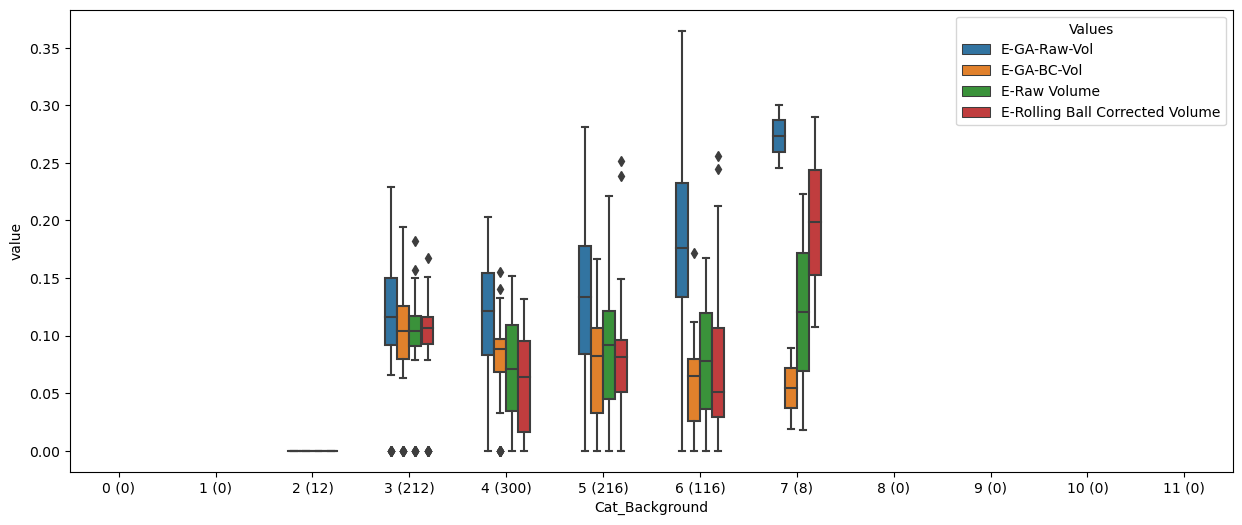

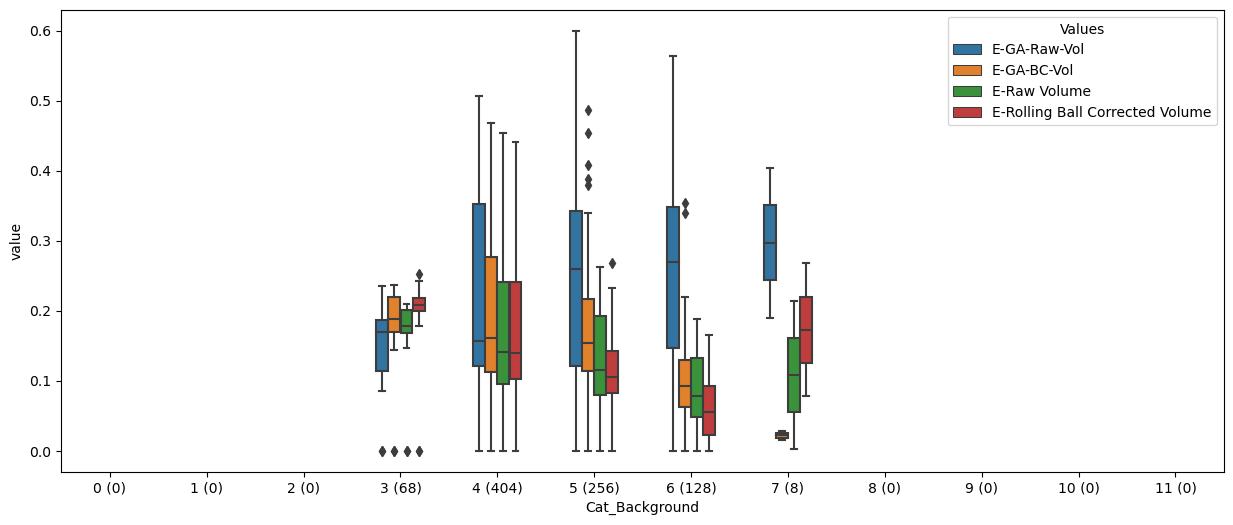

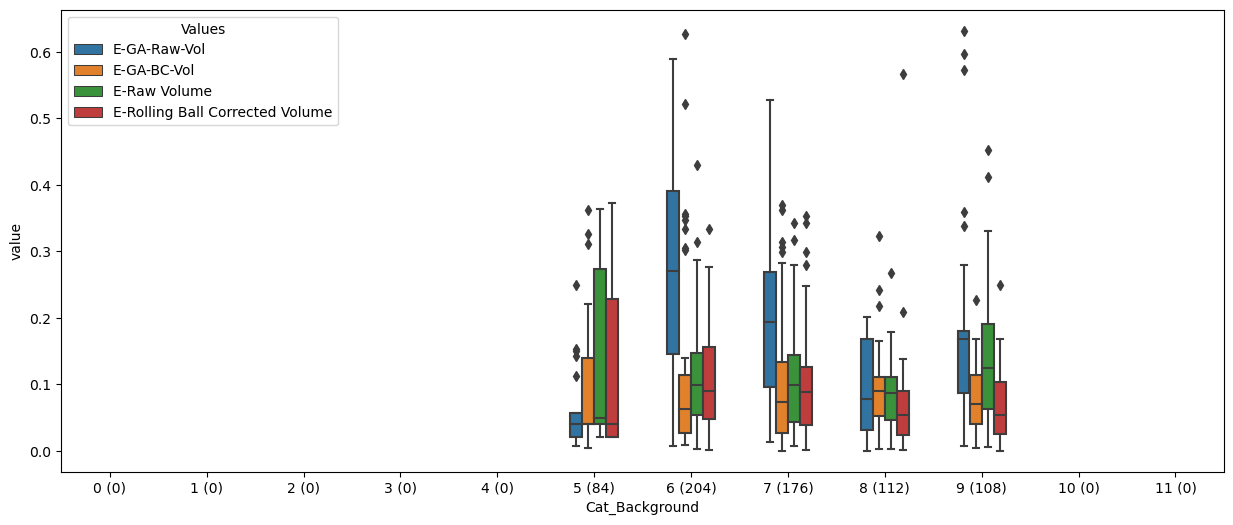

In [138]:
# per gel boxplots, categorised by one of the binned values generated earlier
# TODO: how are there so many high-error values (1.0+)?  Need to investigate
selected_gels = [0,1,2,4,29]
target_x = 'Cat_Background'
quantities = ['GA-Raw-Vol', 'GA-BC-Vol','Raw Volume', 'Rolling Ball Corrected Volume', 'Global Corrected Volume', 'Local Corrected Volume']

all_bins = range(12)

for gelid in selected_gels:
    ref_vals = reference_df[reference_df['Ladder'] == ladder_dict[gelid]] # extract the ladder related to the selected gel
    ref_vals = ref_vals.drop(columns=['Ladder', 'Normalized_Intensity'])
    ref_vals.rename(columns={'Intensity':'Reference Value'},inplace=True)
    columns_to_extract = ['Lane ID', 'Band ID', target_x]
    temp_combo_df = adaptive_normalisation(origin_data[gelid], ref_vals, columns_to_extract) # run adaptive norm on ladder

    for index, quantity in enumerate(quantities): # calculate error quantities
        quant_data = norm_by_lane(origin_data[gelid], quantity)
        temp_combo_df[quantity] = quant_data
        temp_combo_df['E-%s' % quantity] = np.abs(temp_combo_df['Reference Value']-quant_data)

    plt.figure(figsize=(15, 6))

    # melts data for plotting
    df_melted = pd.melt(temp_combo_df, id_vars=[target_x], 
                        value_vars=['E-GA-Raw-Vol', 'E-GA-BC-Vol', 'E-Raw Volume', 'E-Rolling Ball Corrected Volume'], 
                        var_name='Values')
    
    ax = sns.boxplot(x=target_x, y='value', hue='Values', data=df_melted, width=0.5,order=all_bins)

    x_label = []
    # Adds text annotations for the number of instances in each boxplot
    for category in all_bins:
        num_instances = df_melted[df_melted[target_x] == category]['Values'].count()
        x_label.append('%s (%s)' % (category, num_instances))
    ax.set_xticklabels(x_label)

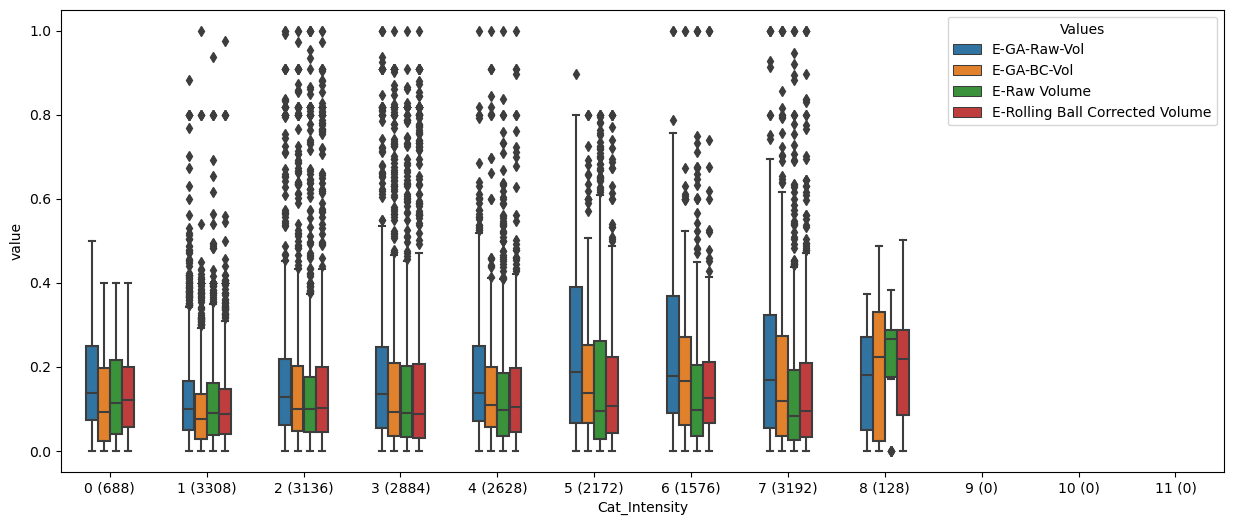

In [136]:
# full dataset boxplots
# TODO: Again, why are there so many 1.0 error values?  Something must be going wrong
selected_gels = origin_data.keys()
target_x = 'Cat_Intensity'
quantities = ['GA-Raw-Vol', 'GA-BC-Vol','Raw Volume', 'Rolling Ball Corrected Volume', 'Global Corrected Volume', 'Local Corrected Volume']

for g_index, gelid in enumerate(selected_gels):
    ref_vals = reference_df[reference_df['Ladder'] == ladder_dict[gelid]]
    ref_vals = ref_vals.drop(columns=['Ladder', 'Normalized_Intensity'])
    ref_vals.rename(columns={'Intensity':'Reference Value'},inplace=True)
    columns_to_extract = ['Lane ID', 'Band ID', target_x]

    # combines all data into a single big dataframe here
    if g_index == 0:
        temp_combo_df = adaptive_normalisation(origin_data[gelid].reset_index(), ref_vals, columns_to_extract)
        temp_combo_df['Gel ID'] = gelid
        for index, quantity in enumerate(quantities):
            quant_data = norm_by_lane(origin_data[gelid], quantity)
            temp_combo_df[quantity] = quant_data
            temp_combo_df['E-%s' % quantity] = np.abs(temp_combo_df['Reference Value']-quant_data)
    else:
        tdf2 = adaptive_normalisation(origin_data[gelid].reset_index(), ref_vals, columns_to_extract)
        tdf2['Gel ID'] = gelid
        for index, quantity in enumerate(quantities):
            quant_data = norm_by_lane(origin_data[gelid], quantity)
            tdf2[quantity] = quant_data
            tdf2['E-%s' % quantity] = np.abs(tdf2['Reference Value']-quant_data)
        temp_combo_df = pd.concat([temp_combo_df, tdf2], ignore_index=True)

plt.figure(figsize=(15, 6))
# melts data for plotting
df_melted = pd.melt(temp_combo_df, id_vars=[target_x], value_vars=['E-GA-Raw-Vol', 'E-GA-BC-Vol', 'E-Raw Volume', 'E-Rolling Ball Corrected Volume'], var_name='Values')
ax = sns.boxplot(x=target_x, y='value', hue='Values', data=df_melted, width=0.5,order=all_bins)

x_label = []
# Adds text annotations for the number of instances in each boxplot
for category in all_bins:
    num_instances = df_melted[df_melted[target_x] == category]['Values'].count()
    x_label.append('%s (%s)' % (category, num_instances))
ax.set_xticklabels(x_label)   
pass

### JUST TESTING

Lane ID                               3.500000
Band ID                               9.500000
Reference Value                       0.155556
GG Raw Volume                         0.246457
E-GG Raw Volume                       0.160872
GA Raw Volume                         0.267290
E-GA Raw Volume                       0.179781
GA Background Corrected Volume        0.256573
E-GA Background Corrected Volume      0.178642
GG Rolling Ball Corrected Volume      0.238233
E-GG Rolling Ball Corrected Volume    0.160154
GG Global Corrected Volume            0.293980
E-GG Global Corrected Volume          0.210667
GG Local Corrected Volume             0.238107
E-GG Local Corrected Volume           0.161271
dtype: float64


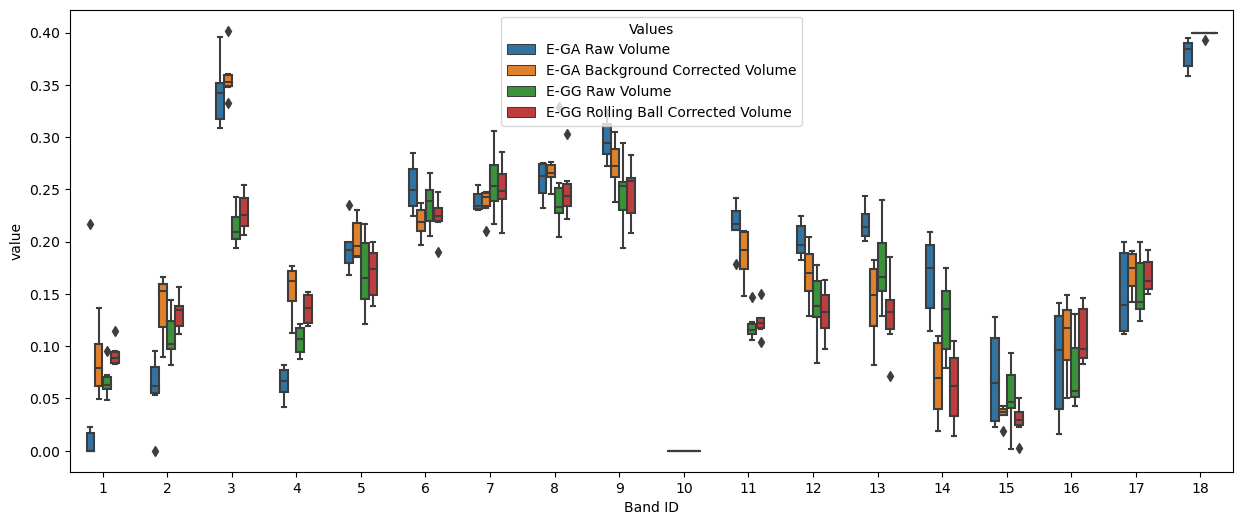

In [37]:
selected_gels = [6]
ladder = 'Thermo'
ref_vals = reference_df[reference_df['Ladder'] == ladder]
ref_vals = ref_vals.drop(columns=['Ladder', 'Intensity'])
ref_vals.rename(columns={'Normalized_Intensity':'Reference Value'},inplace=True)
for gelid in selected_gels:
    dfi = {'GG':gg_dfs['gg_%d' % gelid], 
           'GA': ga_dfs['ga_%d' % gelid]}
    
    quantities = ['Raw Volume', 'Raw Volume', 'Background Corrected Volume', 'Rolling Ball Corrected Volume', 'Global Corrected Volume', 'Local Corrected Volume']
    abbrvs = ['GG', 'GA', 'GA', 'GG', 'GG', 'GG']
    columns_to_extract = ['Lane ID', 'Band ID']
    plt.figure(figsize=(15, 6))
    temp_combo_df = gg_dfs['gg_%d' % gelid][columns_to_extract].copy()
    temp_combo_df = pd.merge(temp_combo_df, ref_vals, on=['Band ID'], how='left')
    
    for index, (quantity, abbrv) in enumerate(zip(quantities, abbrvs)):
        quant_data = norm_by_lane(dfi[abbrv], quantity)
        temp_combo_df['%s %s' % (abbrv, quantity)] = quant_data
        temp_combo_df['E-%s %s' % (abbrv, quantity)] = np.abs(temp_combo_df['Reference Value']-quant_data)

    lane_chop = 6
    temp_combo_df = temp_combo_df[temp_combo_df['Lane ID'] <= lane_chop]
    
    df_melted = pd.melt(temp_combo_df, id_vars=['Band ID'], value_vars=['E-GA Raw Volume', 'E-GA Background Corrected Volume', 'E-GG Raw Volume', 'E-GG Rolling Ball Corrected Volume'], var_name='Values')
    
    sns.boxplot(x='Band ID', y='value', hue='Values', data=df_melted, width=0.5)
    # sns.boxplot(temp_combo_df, x='Band ID', y='GG Raw Volume')

    # plt.scatter(reference_df[reference_df['Ladder'] == 'NEB']['Band ID']-1, reference_df[reference_df['Ladder'] == 'NEB']['Normalized_Intensity'],c='red')
    print(temp_combo_df.mean())

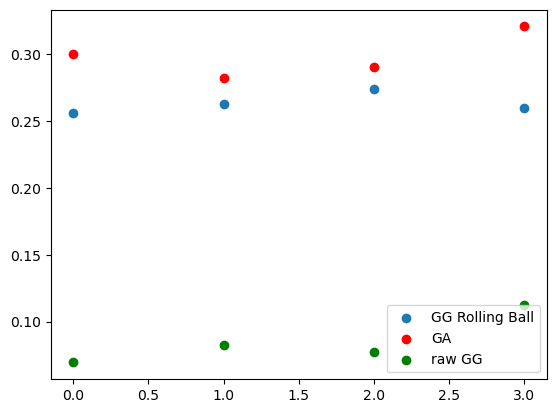

In [124]:
lane_count = 4
sel_df = temp_combo_df[temp_combo_df['Band ID'] == 15]
plt.scatter(range(lane_count), sel_df['E-GG Rolling Ball Corrected Volume'], label='GG Rolling Ball')
plt.scatter(range(lane_count), sel_df['E-GA Background Corrected Volume'],c='red', label='GA')
plt.scatter(range(lane_count), sel_df['E-GG Raw Volume'],c='green',label='raw GG')
plt.legend()

In [6]:
for key, df in ga_dfs.items():
    id = int(key.split('_')[-1])
    print(id,len(ga_dfs[key]), len(gg_dfs['gg_%s' % id]), len(origin_data[id]))

0 216 216 216
1 216 216 216
2 216 216 216
3 216 216 216
4 216 216 216
5 216 216 216
6 216 216 216
7 216 216 216
8 216 216 186
9 216 203 159
10 216 203 180
11 216 191 179
12 216 180 149
13 76 76 76
14 38 27 25
15 76 76 76
16 38 27 27
17 38 27 27
18 76 76 76
19 76 76 76
20 76 76 76
21 228 228 228
22 228 228 228
23 228 228 228
24 228 228 228
25 72 120 72
26 72 120 72
27 72 108 72
29 171 171 171
31 228 228 228
32 216 216 216
33 100 148 100
34 216 216 216


In [110]:
reference_df

,Band ID,Ladder,Intensity,Normalized_Intensity
0,1,NEB,40.0,0.168317
1,2,NEB,40.0,0.168317
2,3,NEB,48.0,0.247525
3,4,NEB,40.0,0.168317
4,5,NEB,32.0,0.089109
5,6,NEB,120.0,0.960396
6,7,NEB,40.0,0.168317
7,8,NEB,57.0,0.336634
8,9,NEB,45.0,0.217822
9,10,NEB,122.0,0.980198
